In [2]:
import numpy as np, tensorflow as tf, random, os
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, concatenate, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
train_dir = 'C:/Users/Maitr/Desktop/Final Documents/new data/train'
test_dir = 'C:/Users/Maitr/Desktop/Final Documents/new data/Test_Rescaled'

In [5]:

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range=[0.8, 1.2],
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_data.class_indices)


Found 4448 images belonging to 4 classes.
Found 1846 images belonging to 4 classes.


In [6]:
tf.keras.backend.clear_session()

In [7]:
input_tensor = Input(shape=(224, 224, 3), name='shared_input')

In [8]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [9]:
resnet_out = resnet_base(input_tensor)      
densenet_out = densenet_base(input_tensor) 

In [10]:
res_feat = GlobalAveragePooling2D(name='gap_resnet')(resnet_out)
den_feat = GlobalAveragePooling2D(name='gap_densenet')(densenet_out)


In [11]:
merged = concatenate([res_feat, den_feat], name='concat_features')

In [12]:
x = Dense(512, activation='relu', name='fc1')(merged)
x = Dropout(0.5, name='dropout')(x)
output = Dense(num_classes, activation='softmax', name='predictions')(x)

In [13]:
model = Model(inputs=input_tensor, outputs=output, name='resnet_densenet_hybrid')


In [14]:
for layer in resnet_base.layers:
    layer.trainable = False
for layer in densenet_base.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "resnet_densenet_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ shared_input (InputLayer)     │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet50 (Functional)         │ (None, 7, 7, 2048)        │      23,587,712 │ shared_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ densenet121 (Functional)      │ (None, 7, 7, 1024)        │       7,037,504 │ shared_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gap_resnet                    │ (None, 2048)              │               0 │ resnet50[0][0]             │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gap_densenet                  │ (None, 1024)              │               0 │ densenet121[0][0]          │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concat_features (Concatenate) │ (None, 3072)              │               0 │ gap_resnet[0][0],          │
│                               │                           │                 │ gap_densenet[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ fc1 (Dense)                   │ (None, 512)               │       1,573,376 │ concat_features[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ fc1[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ predictions (Dense)           │ (None, 4)                 │           2,052 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 32,200,644 (122.84 MB)

 Trainable params: 1,575,428 (6.01 MB)

 Non-trainable params: 30,625,216 (116.83 MB)

In [15]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('hybrid_model.keras', save_best_only=True, monitor='val_accuracy')
]

In [16]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=callbacks
)

C:\Users\Maitr\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.7147 - loss: 0.7306 - val_accuracy: 0.7524 - val_loss: 0.5896
Epoch 2/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.8527 - loss: 0.4148 - val_accuracy: 0.7562 - val_loss: 0.6325
Epoch 3/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step - accuracy: 0.8781 - loss: 0.3371 - val_accuracy: 0.8072 - val_loss: 0.5024
Epoch 4/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 536s 2s/step - accuracy: 0.9040 - loss: 0.2866 - val_accuracy: 0.8629 - val_loss: 0.3537
Epoch 5/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 722s 3s/step - accuracy: 0.9071 - loss: 0.2640 - val_accuracy: 0.8277 - val_loss: 0.4456
Epoch 6/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.9191 - loss: 0.2307 - val_accuracy: 0.8483 - val_loss: 0.4032
Epoch 7/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.9229 - loss: 0.2278 - val_accuracy: 0.8727 - val_loss: 0.3343
Epoch 8/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - accuracy: 0.9274 - loss: 0.2096 - val_accu

In [17]:
loss, acc = model.evaluate(test_data)
print(f" Final Test Accuracy: {acc*100:.2f}%")

116/116 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9247 - loss: 0.2048
 Final Test Accuracy: 92.47%


In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "C:/Users/Maitr/Desktop/Final Documents/new data/Test_Rescaled/Onychomycosis/rescaled_1_6136416.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0

pred = model.predict(x)[0]
labels = list(train_data.class_indices.keys())
for i, label in enumerate(labels):
    print(f"{label}: {pred[i]:.4f}")

print("Predicted:", labels[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Healthy_Augmented: 0.0032
Onychomycosis_Augmented: 0.9968
Tinea Corporis_Augmented: 0.0000
Tinea Nigra_Augmented: 0.0000
Predicted: Onychomycosis_Augmented


In [20]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "C:/Users/Maitr/Desktop/WhatsApp Image 2025-11-13 at 8.06.48 PM.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0

pred = model.predict(x)[0]
labels = list(train_data.class_indices.keys())
for i, label in enumerate(labels):
    print(f"{label}: {pred[i]:.4f}")

print("Predicted:", labels[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Healthy_Augmented: 0.0849
Onychomycosis_Augmented: 0.9150
Tinea Corporis_Augmented: 0.0000
Tinea Nigra_Augmented: 0.0001
Predicted: Onychomycosis_Augmented


In [21]:

from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "C:/Users/Maitr/Desktop/Final Documents/new data/Test_Rescaled/Tinea Corporis/rescaled_17_8801106.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0

pred = model.predict(x)[0]
labels = list(train_data.class_indices.keys())
for i, label in enumerate(labels):
    print(f"{label}: {pred[i]:.4f}")

print("Predicted:", labels[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Healthy_Augmented: 0.0101
Onychomycosis_Augmented: 0.0000
Tinea Corporis_Augmented: 0.9898
Tinea Nigra_Augmented: 0.0001
Predicted: Tinea Corporis_Augmented


In [22]:

from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "C:/Users/Maitr/Desktop/Final Documents/new data/Test_Rescaled/Tinea Nigra/rescaled_25_1234389.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0

pred = model.predict(x)[0]
labels = list(train_data.class_indices.keys())
for i, label in enumerate(labels):
    print(f"{label}: {pred[i]:.4f}")

print("Predicted:", labels[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Healthy_Augmented: 0.0002
Onychomycosis_Augmented: 0.0000
Tinea Corporis_Augmented: 0.0078
Tinea Nigra_Augmented: 0.9920
Predicted: Tinea Nigra_Augmented


In [23]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "C:/Users/Maitr/Desktop/WhatsApp Image 2025-11-14 at 2.16.48 AM.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0

pred = model.predict(x)[0]
labels = list(train_data.class_indices.keys())
for i, label in enumerate(labels):
    print(f"{label}: {pred[i]:.4f}")

print("Predicted:", labels[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Healthy_Augmented: 0.8171
Onychomycosis_Augmented: 0.0060
Tinea Corporis_Augmented: 0.1679
Tinea Nigra_Augmented: 0.0090
Predicted: Healthy_Augmented


In [23]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "C:/Users/Maitr/Desktop/WhatsApp Image 2025-11-14 at 2.16.48 AM.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0

pred = model.predict(x)[0]
labels = list(train_data.class_indices.keys())
for i, label in enumerate(labels):
    print(f"{label}: {pred[i]:.4f}")

print("Predicted:", labels[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Healthy_Augmented: 0.8171
Onychomycosis_Augmented: 0.0060
Tinea Corporis_Augmented: 0.1679
Tinea Nigra_Augmented: 0.0090
Predicted: Healthy_Augmented


In [24]:

from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "C:/Users/Maitr/Desktop/WhatsApp Image 2025-11-14 at 2.19.58 AM.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0

pred = model.predict(x)[0]
labels = list(train_data.class_indices.keys())
for i, label in enumerate(labels):
    print(f"{label}: {pred[i]:.4f}")

print("Predicted:", labels[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Healthy_Augmented: 0.9997
Onychomycosis_Augmented: 0.0000
Tinea Corporis_Augmented: 0.0000
Tinea Nigra_Augmented: 0.0003
Predicted: Healthy_Augmented


In [25]:

model.save("fungal_hybrid_model.h5")
print(" Model saved successfully!")


 Model saved successfully!


In [89]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [90]:
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc * 100:.2f}%")


116/116 ━━━━━━━━━━━━━━━━━━━━ 103s 825ms/step - accuracy: 0.9247 - loss: 0.2048
Test Accuracy: 92.47%


In [91]:
loss_train, acc_train = model.evaluate(train_data)
print(f"Train Accuracy: {acc_train * 100:.2f}%")


278/278 ━━━━━━━━━━━━━━━━━━━━ 225s 807ms/step - accuracy: 0.9672 - loss: 0.0958
Train Accuracy: 96.72%


In [92]:
import numpy as np
true_labels = test_data.classes
pred_probs = model.predict(test_data)
pred_labels = np.argmax(pred_probs, axis=1)


116/116 ━━━━━━━━━━━━━━━━━━━━ 103s 856ms/step


In [93]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[1383   10   85   35]
 [   1  157    1    0]
 [   3    0   54    0]
 [   0    0    4  113]]


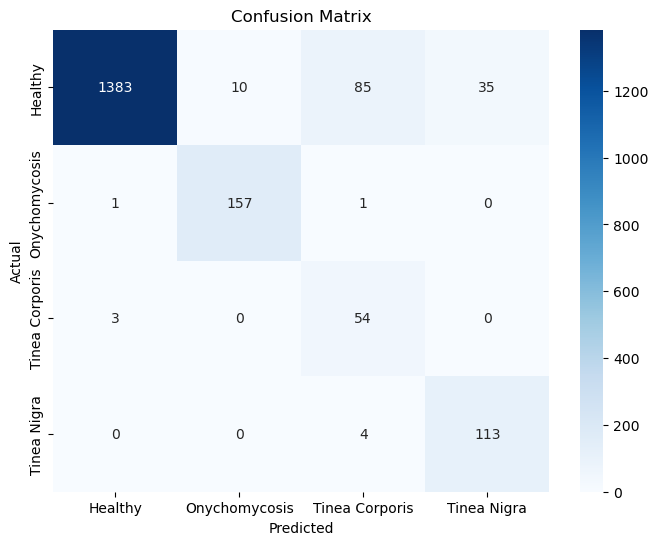

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = list(test_data.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [95]:
from sklearn.metrics import classification_report

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names))



CLASSIFICATION REPORT:

                precision    recall  f1-score   support

       Healthy       1.00      0.91      0.95      1513
 Onychomycosis       0.94      0.99      0.96       159
Tinea Corporis       0.38      0.95      0.54        57
   Tinea Nigra       0.76      0.97      0.85       117

      accuracy                           0.92      1846
     macro avg       0.77      0.95      0.83      1846
  weighted avg       0.96      0.92      0.94      1846



In [96]:
import numpy as np

print("\nACCURACY PER CLASS:\n")

for i, class_name in enumerate(class_names):
    class_indices = np.where(true_labels == i)[0]        
    class_correct = np.sum(pred_labels[class_indices] == i)
    class_total = len(class_indices)
    
    accuracy = class_correct / class_total
    print(f"{class_name}: {accuracy * 100:.2f}%")



ACCURACY PER CLASS:

Healthy: 91.41%
Onychomycosis: 98.74%
Tinea Corporis: 94.74%
Tinea Nigra: 96.58%


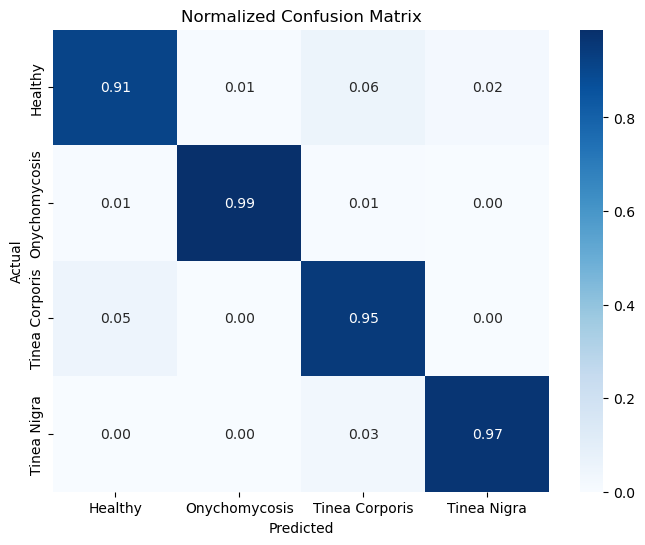

In [97]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(true_labels, pred_labels, normalize="true")

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, 
            yticklabels=class_names, fmt=".2f")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()


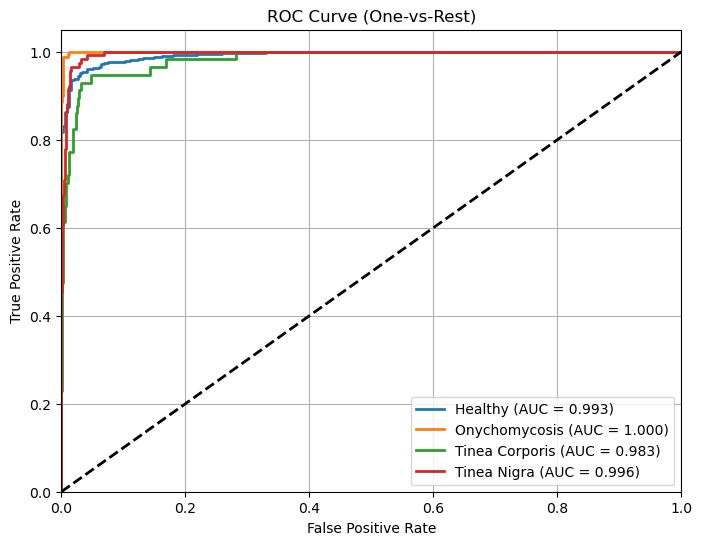

In [98]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
true_onehot = to_categorical(true_labels, num_classes=num_classes)
num_classes = len(class_names)
plt.figure(figsize=(8,6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_onehot[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [99]:
from sklearn.metrics import roc_auc_score


print("AUC SCORE PER CLASS:\n")
for i in range(num_classes):
    auc_score = roc_auc_score(true_onehot[:, i], pred_probs[:, i])
    print(f"{class_names[i]}: {auc_score:.3f}")


micro_auc = roc_auc_score(true_onehot, pred_probs, average="micro")

macro_auc = roc_auc_score(true_onehot, pred_probs, average="macro")

print("\nMicro-average AUC:", round(micro_auc, 3))
print("Macro-average AUC:", round(macro_auc, 3))


AUC SCORE PER CLASS:

Healthy: 0.993
Onychomycosis: 1.000
Tinea Corporis: 0.983
Tinea Nigra: 0.996

Micro-average AUC: 0.992
Macro-average AUC: 0.993


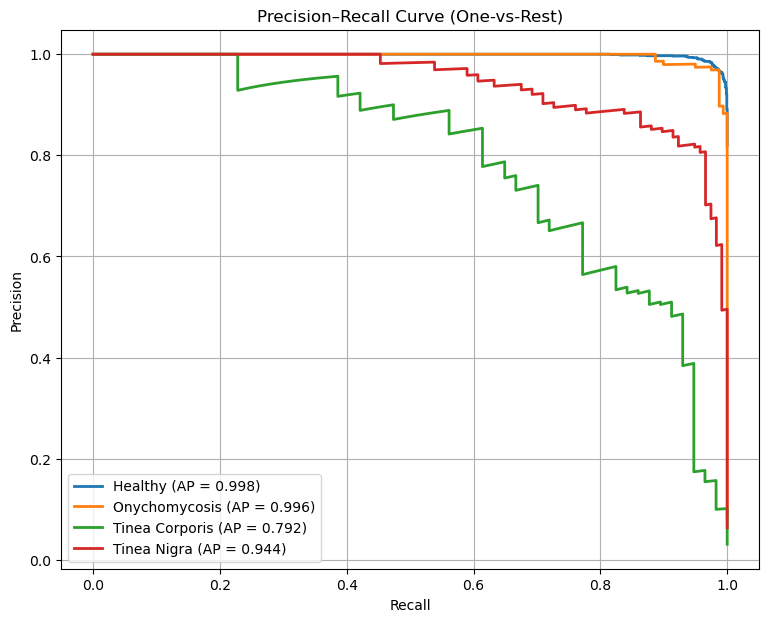

In [100]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
true_onehot = to_categorical(true_labels, num_classes=num_classes)
plt.figure(figsize=(9, 7))

for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(true_onehot[:, i], pred_probs[:, i])
    ap_score = average_precision_score(true_onehot[:, i], pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f"{class_names[i]} (AP = {ap_score:.3f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (One-vs-Rest)')
plt.grid(True)
plt.legend(loc="lower left")
plt.show()

In [103]:
import os
print(os.getcwd())


C:\Users\Maitr


In [105]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "C:/Users/Maitr/Desktop/accuracy check/new data/Test_Rescaled/Tinea Nigra/rescaled_51_5301563.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0

pred = model.predict(x)[0]
labels = list(train_data.class_indices.keys())
for i, label in enumerate(labels):
    print(f"{label}: {pred[i]:.4f}")

print("Predicted:", labels[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Healthy_Augmented: 0.0037
Onychomycosis_Augmented: 0.0000
Tinea Corporis_Augmented: 0.0252
Tinea Nigra_Augmented: 0.9710
Predicted: Tinea Nigra_Augmented


In [107]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "C:/Users/Maitr/Desktop/Final Documents/new data/Test_Rescaled/Onychomycosis/rescaled_0_5054630.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) / 255.0

pred = model.predict(x)[0]
labels = list(train_data.class_indices.keys())
for i, label in enumerate(labels):
    print(f"{label}: {pred[i]:.4f}")

print("Predicted:", labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Healthy_Augmented: 0.0001
Onychomycosis_Augmented: 0.9999
Tinea Corporis_Augmented: 0.0000
Tinea Nigra_Augmented: 0.0000
Predicted: Onychomycosis_Augmented
